In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import warnings
import segyio

import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import dill

sys.path.append('..')
from seismiqb.batchflow import Dataset, Pipeline, FilesIndex
from seismiqb.batchflow import B, V, C, L, F, D, P, R
from seismiqb.batchflow.models.tf import UNet, TFModel
from seismiqb.batchflow.models.tf.layers import conv_block
from seismiqb import SeismicCropBatch, SeismicGeometry, SeismicCubeset
from seismiqb import convert_point_cloud, dump_horizon, convert_to_numba_dict, compute_running_mean

from glob import glob
from tqdm import tqdm
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import logging

In [2]:
%%time
path_data = '/notebooks/SEISMIC_DATA/CUBE_1/E_anon.hdf5'
dsi = FilesIndex(path=[path_data], no_ext=True)
ds = SeismicCubeset(dsi)
ds = ds.load()

CPU times: user 23.5 s, sys: 5.6 s, total: 29.1 s
Wall time: 29.1 s


In [3]:
ds.geometries[ds.indices[0]].horizon_listet

['/notebooks/SEISMIC_DATA/CUBE_1/BEST_HORIZONS/etp_B_anon',
 '/notebooks/SEISMIC_DATA/CUBE_1/BEST_HORIZONS/etp_PK1_anon',
 '/notebooks/SEISMIC_DATA/CUBE_1/BEST_HORIZONS/etp_BP6_anon',
 '/notebooks/SEISMIC_DATA/CUBE_1/BEST_HORIZONS/etp_BP9_anon',
 '/notebooks/SEISMIC_DATA/CUBE_1/BEST_HORIZONS/etp_BP12_anon',
 '/notebooks/SEISMIC_DATA/CUBE_1/BEST_HORIZONS/etp_BP16_anon',
 '/notebooks/SEISMIC_DATA/CUBE_1/BEST_HORIZONS/etp_BP4_anon',
 '/notebooks/SEISMIC_DATA/CUBE_1/BEST_HORIZONS/etp_BP10_anon',
 '/notebooks/SEISMIC_DATA/CUBE_1/BEST_HORIZONS/etp_BP14_anon']

In [4]:
il_offset = ds.geometries[ds.indices[0]].ilines_offset
xl_offset = ds.geometries[ds.indices[0]].xlines_offset

In [6]:
points=(2000,  250, 940)
crop_shape=(1, 700, 100)

In [7]:
ds.labels[ds.indices[0]][(points[0] + il_offset, points[1] + xl_offset)]

array([1086,  386,  885,  909,  950, 1060,  861,  928, 1041])

In [8]:
horizon_idx = 4
ds.geometries[ds.indices[0]].horizon_list[horizon_idx]

'/notebooks/SEISMIC_DATA/CUBE_1/BEST_HORIZONS/etp_BP12_anon'

medfilt


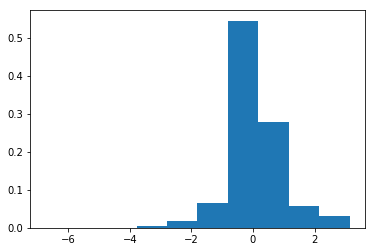

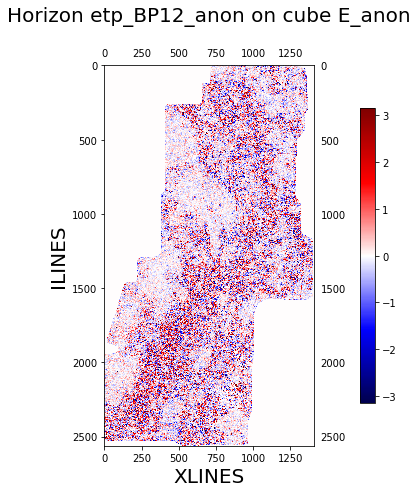

Average phase difference from median is 0.5614665233736024


In [9]:
img, median_phase, phase = ds.compute_hilbert_transform(labels_idx=horizon_idx, window=20, kernel_size=7, _return=True)

Image from E_anon


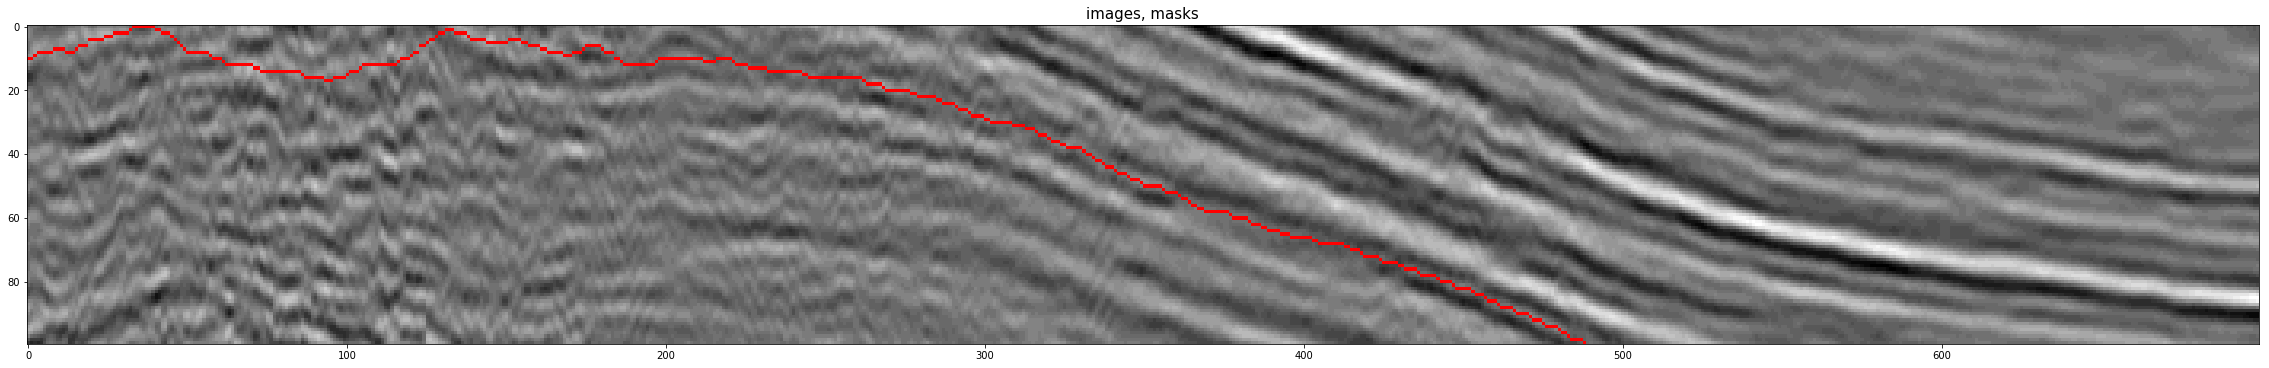

Image from E_anon


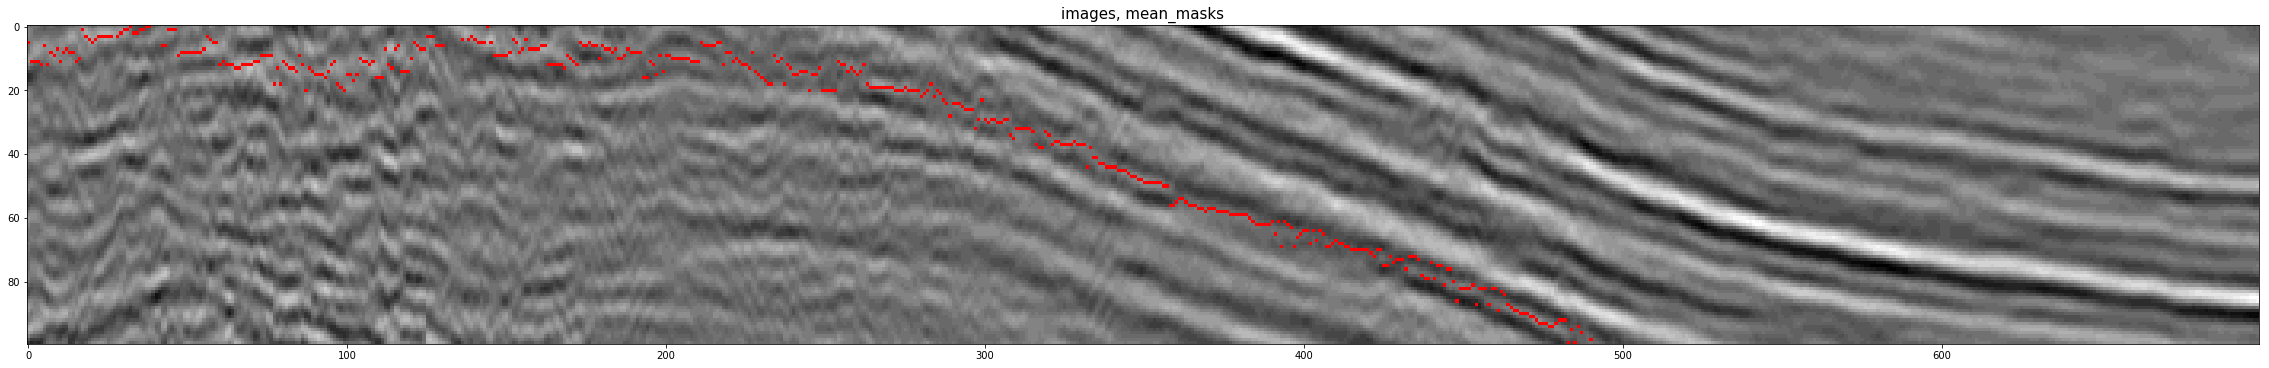

In [19]:
btch_masks, btch_mean_masks = load_slice(ds, points, crop_shape, horizon_idx, ilines=False)

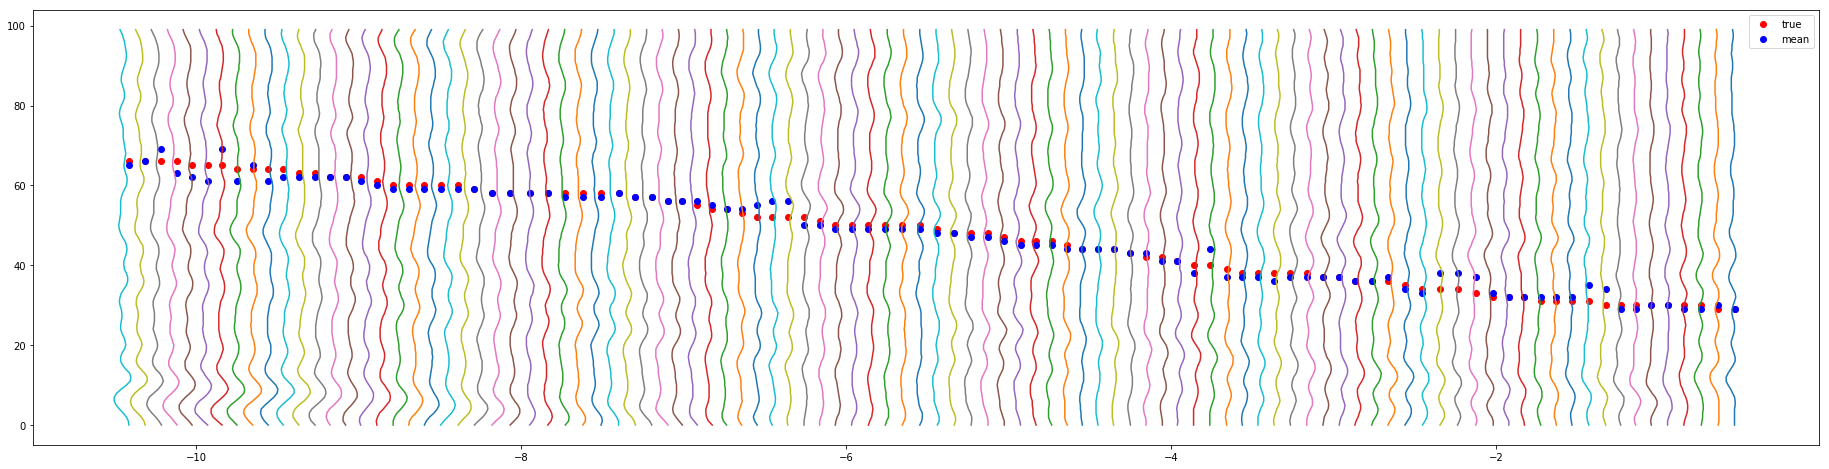

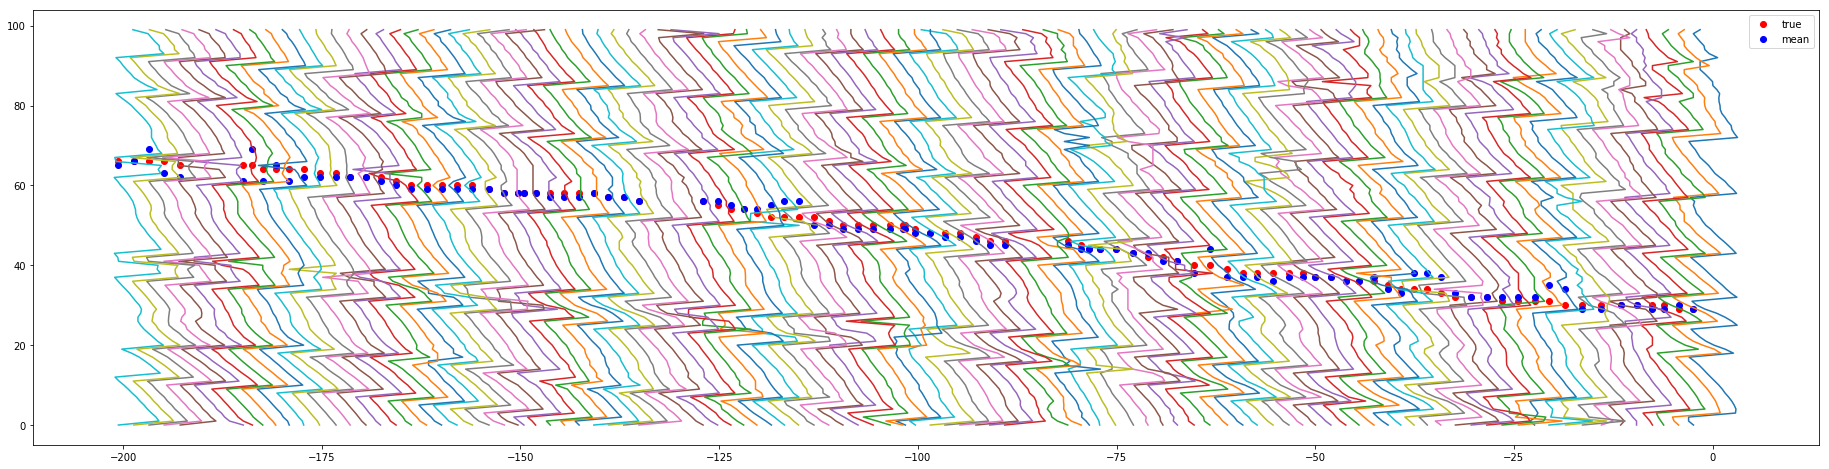

In [29]:
show_btch_slice(btch_masks, btch_mean_masks, ilines=False, x_start=300, x_len=100, t_start=0, t_len=100, figsize=(32, 8))

In [30]:
horizon_idx = 1
ds.geometries[ds.indices[0]].horizon_list[horizon_idx]

'/notebooks/SEISMIC_DATA/CUBE_1/BEST_HORIZONS/etp_PK1_anon'

medfilt


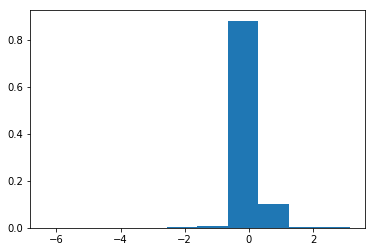

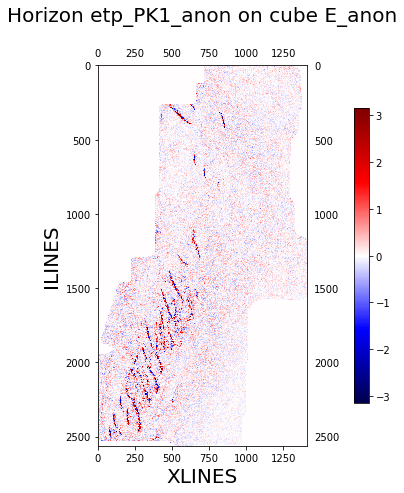

Average phase difference from median is 0.1868079985914374


In [31]:
img, median_phase, phase = ds.compute_hilbert_transform(labels_idx=horizon_idx, window=20, kernel_size=7, _return=True)

In [32]:
points=(2000,  250, None)
crop_shape=(1, 700, 100)

In [33]:
ds.labels[ds.indices[0]][(points[0] + il_offset, points[1] + xl_offset)]

array([1086,  386,  885,  909,  950, 1060,  861,  928, 1041])

In [34]:
points=(2000,  250, 360)

Image from E_anon


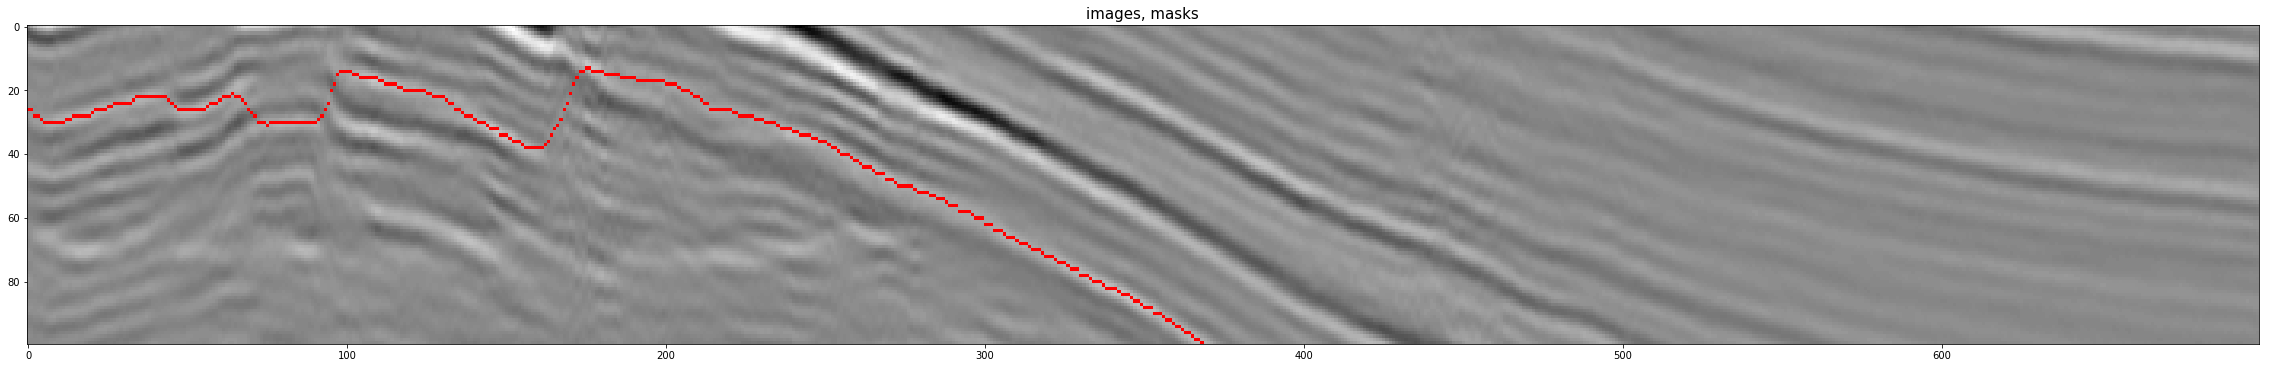

Image from E_anon


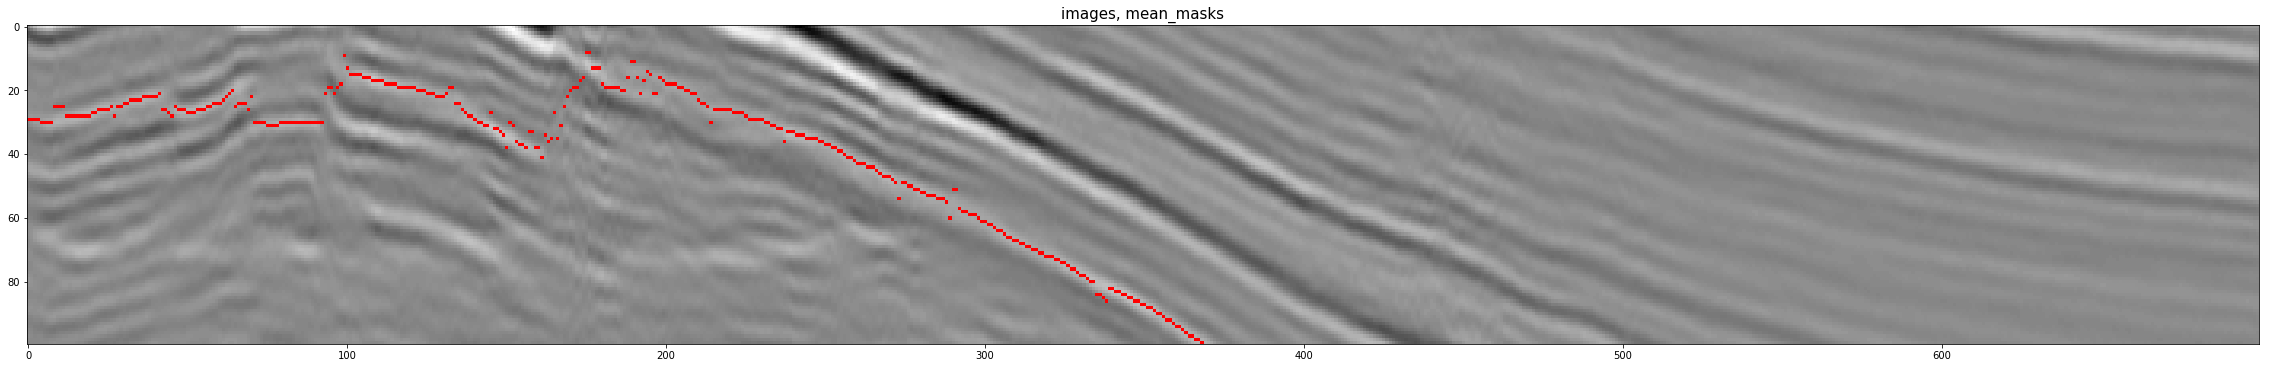

In [44]:
btch_masks, btch_mean_masks = load_slice(ds, points, crop_shape, horizon_idx, ilines=False)

300


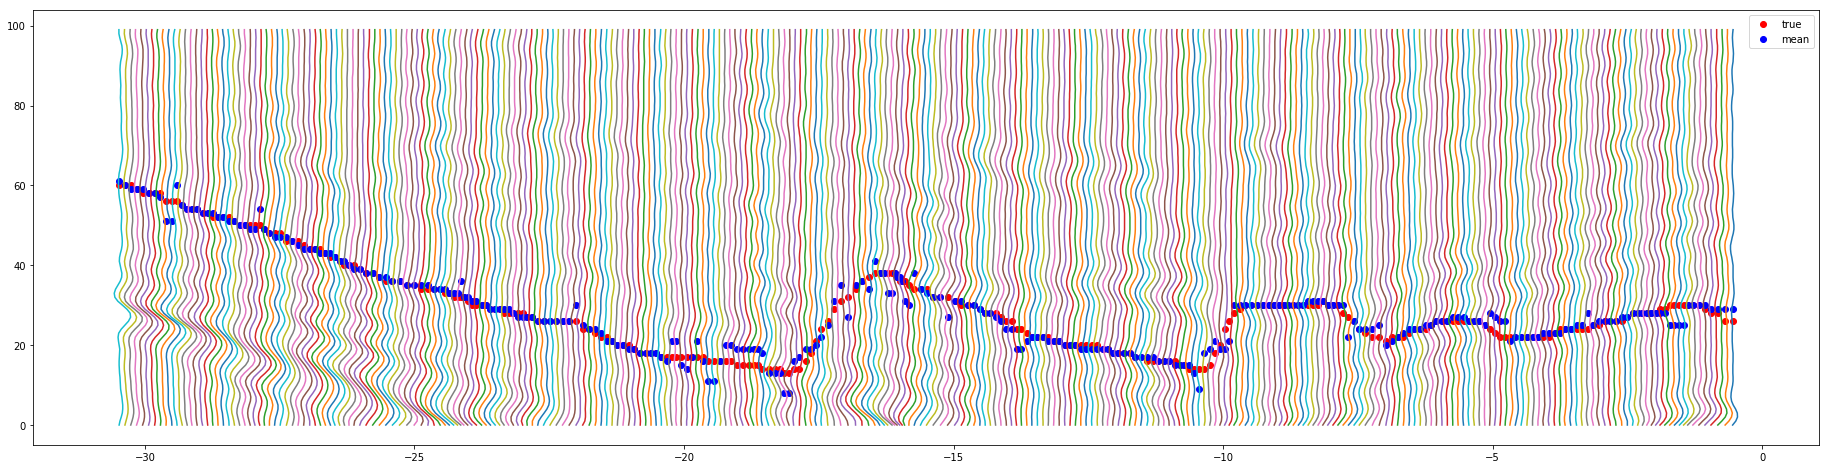

300


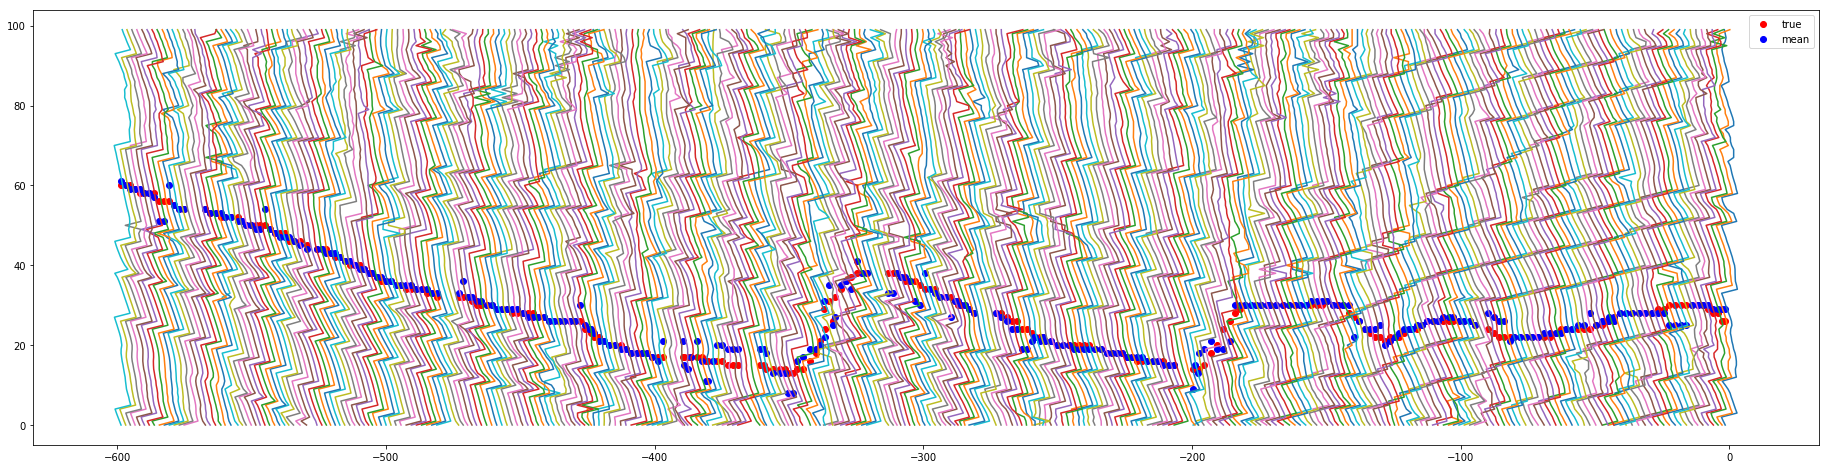

In [51]:
show_btch_slice(btch_masks, btch_mean_masks, ilines=False, x_start=0, x_len=300, t_start=0, t_len=100, figsize=(32, 8))

# P cube

In [ ]:
%%time
path_data = '/notebooks/SEISMIC_DATA/CUBE_3/P_cube.hdf5'
dsi = FilesIndex(path=[path_data], no_ext=True)
ds = SeismicCubeset(dsi)
ds = ds.load()

medfilt


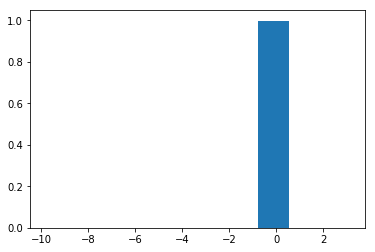

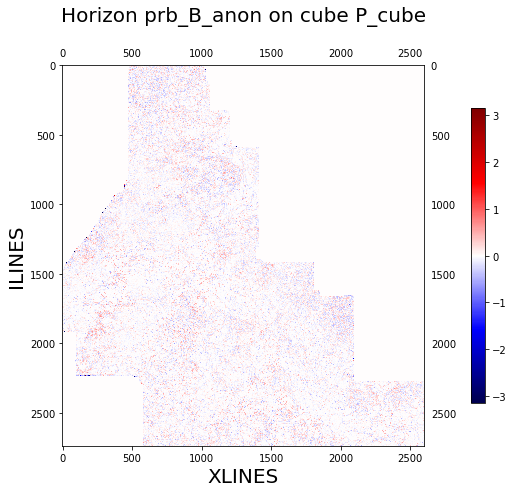

Average phase difference from median is 0.08603973654809215


In [656]:
img, median_phase, phase = ds.compute_hilbert_transform(labels_idx=0, window=20, kernel_size=7, _return=True)

Image from P_cube


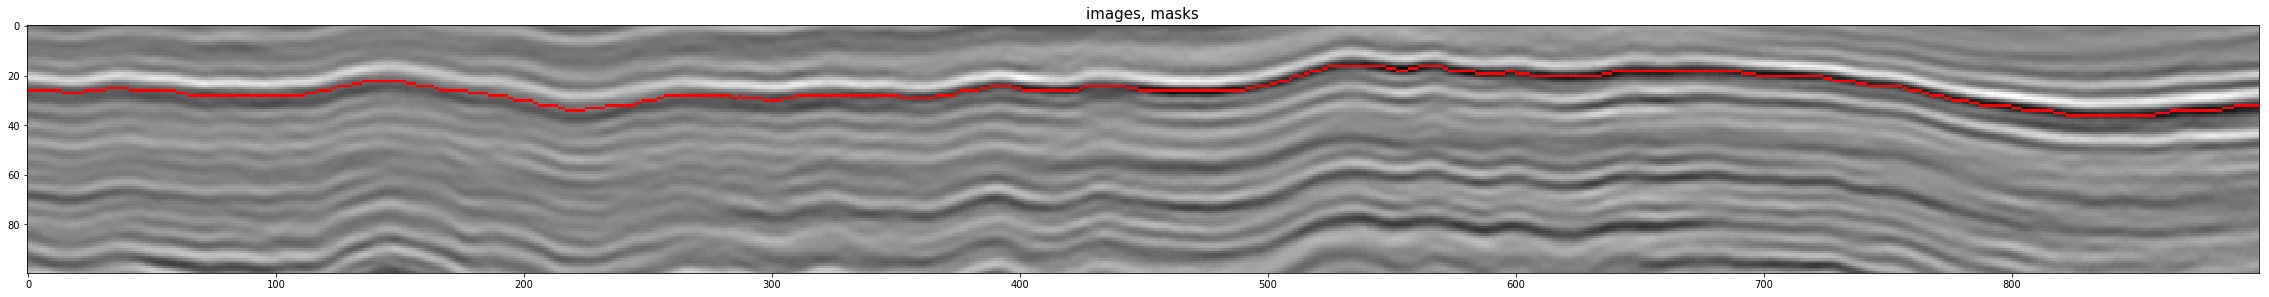

Image from P_cube


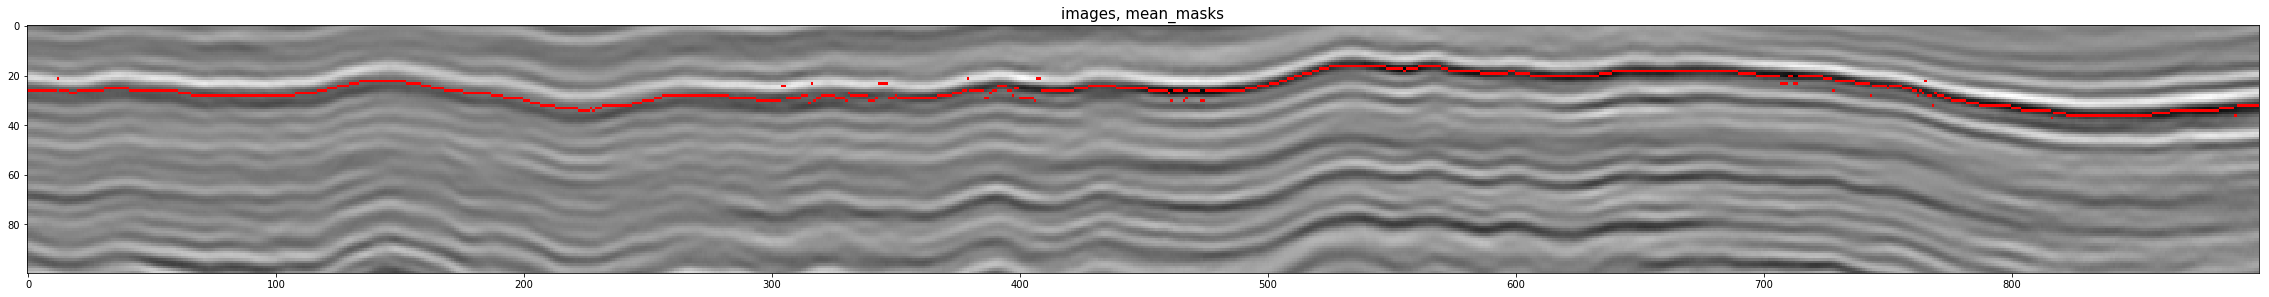

In [681]:
btch_masks, btch_mean_masks = load_slice(ds, (800, 500, 1120), (1, 900, 100), horizon_idx=0, ilines=False)

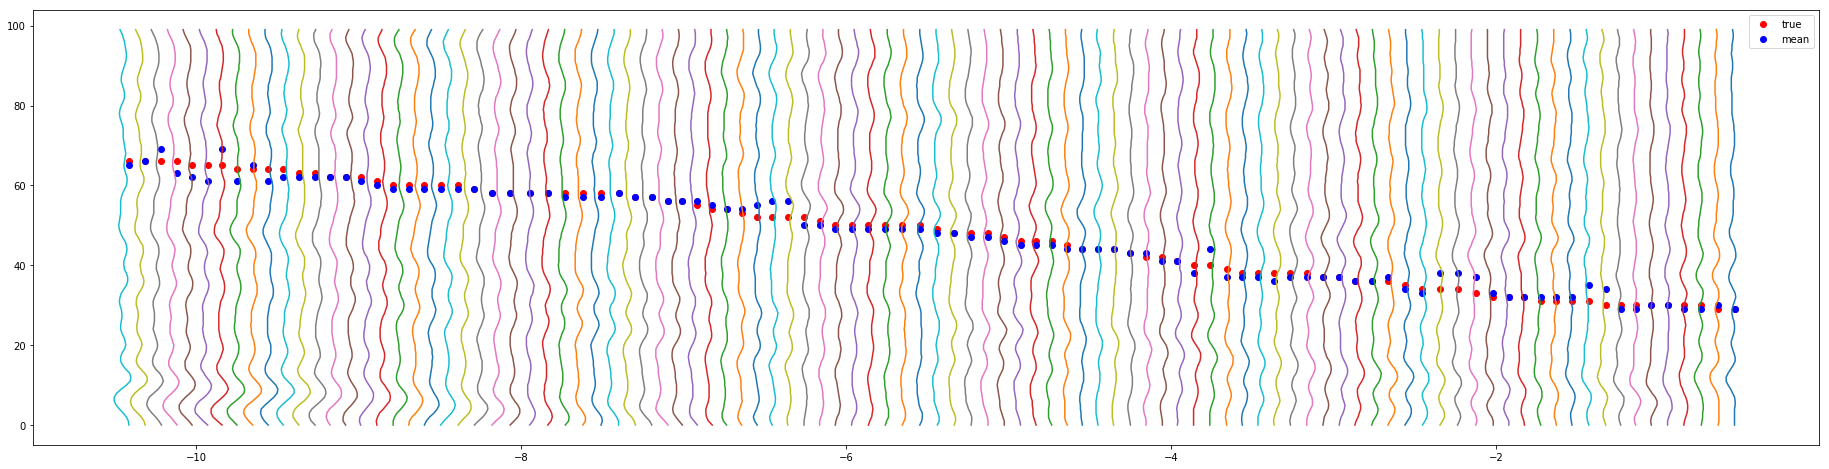

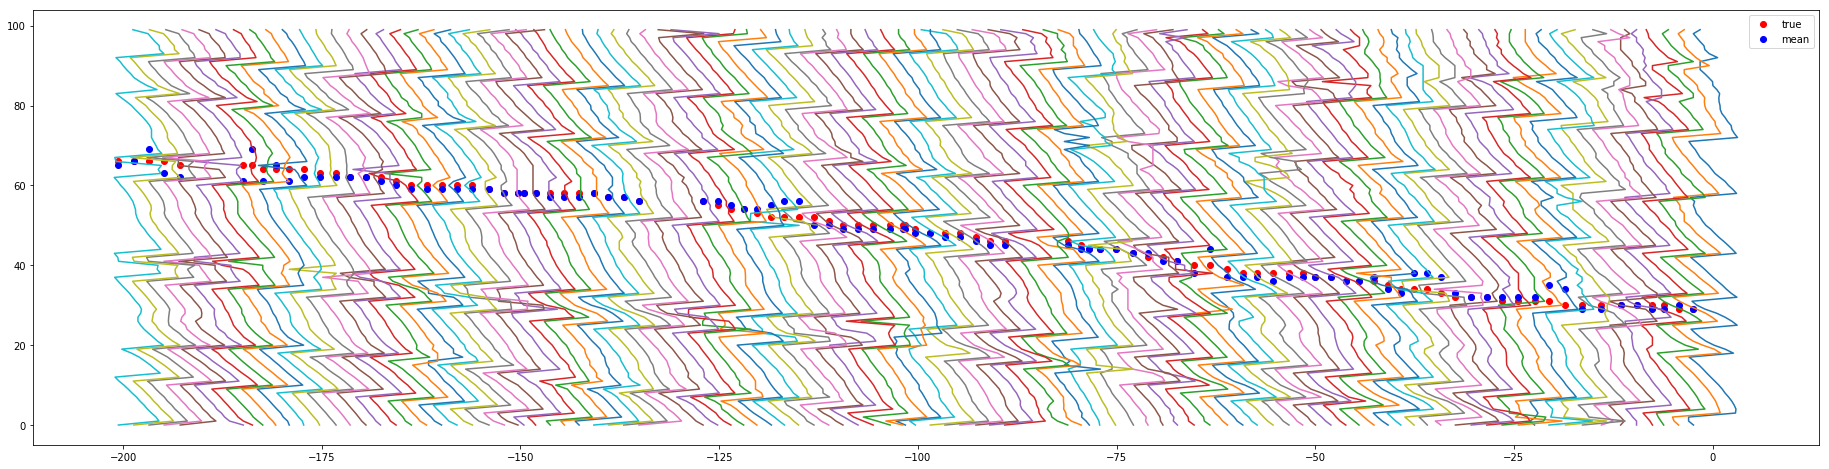

In [28]:
show_btch_slice(btch_masks, btch_mean_masks, ilines=False, x_start=300, x_len=100, t_start=0, t_len=100, figsize=(32, 8))

In [658]:
il_offset = ds.geometries[ds.indices[0]].ilines_offset
xl_offset = ds.geometries[ds.indices[0]].xlines_offset

In [14]:
def update_mean_labels(btch, horizon_idx, eps=5):
    i = 0
    il_0 = btch.slices[i][0][0]
    xl_0 = btch.slices[i][1][0]
    t_0 = btch.slices[i][2][0]
    mean_labels = {}

    for _il in btch.slices[i][0]:
        for _xl in btch.slices[i][1]:
            mean_phase = median_phase[_il, _xl]
            phase_trace = phase[_il, _xl]

            h_coord_true = ds.labels[ds.indices[0]][(_il + il_offset, _xl + xl_offset)][horizon_idx] - t_0
            h_coord = phase.shape[-1] // 2
            min_delta = 100500
            min_coord = 20
            for step in range(-eps, eps):
                delta = np.abs(mean_phase - phase_trace[h_coord + step])
                if delta < min_delta:
                    min_coord = h_coord_true + step
                    min_delta = delta
            mean_labels[(_il + il_offset, _xl + xl_offset)] = [min_coord + t_0]
    return mean_labels

In [18]:
def load_slice(ds, points, crop_shape, horizon_idx, ilines=False):
    axes = (1, 0, 2) if ilines else (0, 1, 2)
    points = np.array([ds.indices[0], *points], dtype=object).reshape((1, -1))
    
    def _load_btch_labels(ds, src_labels='labels', dst='masks'):
        dst_labels = 'btch_labels' if src_labels == 'labels' else src_labels
        preprocessing = (Pipeline()
                            .load_component(src=[D('geometries')],
                                            dst=['geometries'])
                            .add_components(dst_labels) 
                            .crop(points=points, shape=crop_shape, passdown=dst_labels)
                            .load_component(src=D(src_labels), dst=dst_labels)
                            .load_cubes(dst='images')
                            .create_masks(dst=dst, width=0, src_labels=dst_labels, n_horizons=1)
                            .apply_transform(np.transpose, axes=axes, src=['images', dst])
                            .rotate_axes(src=['images', dst])
                            .analytic_transform(src='images', dst='hilbert')
                            .scale(mode='normalize', src='images'))
        show_ppl = preprocessing << ds
        btch = show_ppl.next_batch(len(ds.indices))
        return btch
    btch_masks = _load_btch_labels(ds, src_labels='labels', dst='masks')
    btch_masks.plot_components('images', 'masks', overlap=True, figsize=(40, 50))
    
    mean_labels = update_mean_labels(btch_masks, horizon_idx, eps=5)
    ds.mean_labels = {ds.indices[0]: convert_to_numba_dict(mean_labels)}
    btch_mean_masks= load_btch_labels(ds, src_labels='mean_labels', dst='mean_masks')
    btch_mean_masks.plot_components('images', 'mean_masks', overlap=True, figsize=(40, 50))
    return btch_masks, btch_mean_masks

In [46]:
def plot_wave_image_2(wave_image, masks=None, masks_2=None, step=0.1, linewidth=2, linestyle='-', figsize=(20, 20)):
    plt.figure(figsize=figsize)
    base = plt.gca().transData
    rot = matplotlib.transforms.Affine2D().rotate_deg(90)
    data = [wave_image[i, :, 0] + i * step for i in range(wave_image.shape[0])]
    for i in range(len(data)):
        plt.plot(data[i], transform= rot + base)
    if masks is not None:
        plt.scatter(-np.array(data)[:, 0], np.where(masks != 0)[1], c='r',  label='true')
    if masks_2 is not None:
        plt.scatter(-np.array(data)[:, 0], np.where(masks_2 != 0)[1], c='b',  label='mean')
    plt.legend()
    plt.show()
    for i in range(len(np.where(masks != 0)[1])):
        coord = np.where(masks != 0)[1][i]


def show_btch_slice(btch_masks, btch_mean_masks=None, ilines=False, x_start=0, x_len=100, t_start=0, t_len=100, figsize=(40, 10)):
    mean_masks = btch_masks.masks[0] if not btch_mean_masks else btch_mean_masks.mean_masks[0]
    plot_wave_image_2(btch_masks.images[0][x_start:x_start + x_len, t_start:t_start + t_len, :],
                    btch_masks.masks[0][x_start:x_start + x_len, t_start:t_start + t_len, :], mean_masks[x_start:x_start + x_len, t_start:t_start + t_len, :],
                    figsize=figsize)
    plot_wave_image_2(btch_masks.hilbert[0][x_start:x_start + x_len, t_start:t_start + t_len, :],
                    btch_masks.masks[0][x_start:x_start + x_len, t_start:t_start + t_len, :], mean_masks[x_start:x_start + x_len, t_start:t_start + t_len, :],
                    step=2.0, linewidth=5, linestyle=':', figsize=figsize)